# 01-Creation

Things to do:
1. Initialize root case
    1. take in FASTA file from directory
    2. save FASTA sequence as array of characters
    3. intitialize community, date
2. Create descendent communities
    1. Set number of people in each communitiy
    2. look at SIR rates  - when infected 
        1. infecting x in A - Poisson
        2. infection x in B - Poisson
        3. recovering and leaving R - Gaussian? IDK
        4. select person from each community randomly based on rate
    3. At infection, look at mutation formula and pass onto reciever
    
TODO:
 *  figure out community size x data structure - prob dictionary
 *  how to pick community?
 *  function to actually mutate sequence
    

# 0. Setup

In [4]:
import numpy as np
import scipy.stats as stats
import scipy.special as ssp
import matplotlib.pyplot as plt
import pandas as pd
import random
import datetime
import seaborn as sns

from Bio import SeqIO


In [ ]:
#RUN ME TO COLLECT PRESET DATA
agents = pd.read_csv('sus_all.csv')
gnm = pd.read_csv('all.csv')

In [5]:
np.random.binomial(99,.25)

23

## 0.1 Functions

In [6]:
#from functions import num_infected
def num_infected(rate, Sus_I):
#inner beta, intra beta, arrays of indices for inside and outside group
#returns: arrays of index numbers for those selected
    I_inf = []

    
    num_in = int(np.random.poisson(rate))
    #print('num in: ' + str(num_in))
    #print('num out: ' + str(num_out))
    
    for i in range(num_in):
        if len(Sus_I) == 0:
            break
        I_inf.append(random.choice(Sus_I))
    return I_inf
                     


In [7]:
#==============================================================================
# mutation https://www.nature.com/articles/s41467-020-19818-2 - clock rate
#==============================================================================

def agent_mut_num(rate=0.419):
#adds mutationfor every 3 transmissions
#returns: number of mutations
    mymut = np.random.poisson(rate)
    return mymut


def spot_mutation(num, seq):
#one mutation for every 2-3 transmissions
#returns: new sequence
    swap = random.sample(range(len(seq)), num)
    seq1=seq.copy()
    for i in swap:
        conversion = ['A', 'C', 'T', 'G']
        spot = seq1[i]
        conversion.remove(spot)
        seq1[i] = random.choice(conversion)
    return seq1

In [8]:
def spot_mutation_int(num, seq):
#one mutation for every 2-3 transmissions
#returns: new sequence
    swap = random.sample(range(len(seq)), num)
    seq1=seq.copy()
    for i in swap:
        print(i)
        conversion = [0, 1, 2, 3]
        spot = seq1[i]
        conversion.remove(spot)
        seq1[i] = random.choice(conversion)
    return seq1

In [9]:
w = [1,1,1,2,2,3,0,0,0,0,3,2,1,3,3,3,1]
v = w.copy()

In [10]:
v= spot_mutation_int(agent_mut_num(2),w)
np.array_equal(v,w)

11


False

In [11]:
np.array_equal(v,w)

False

In [12]:
agent_mut_num(30)

35

In [13]:
#==============================================================================
# recovery 
#==============================================================================

def recovery_odds(k=1,theta=10):
#gamma functoin - time until next event
                     #k is number of events (one)
                     #theta is avg num days to infection (10)
#returns: time in days until recovery. save and then check if infection day is higher than that
    day = round(np.random.gamma(k, theta, 1)[0])
    return day

In [17]:
base

{'base_case': SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='base_case', name='base_case', description='base_case', dbxrefs=[])}

In [18]:
base = SeqIO.to_dict(SeqIO.parse('11/data/reference.fasta', 'fasta'))
ref= base['G22670']
refseq = np.array(ref)

In [19]:
refseq2 = []
dik={}
dik['A'] = 0
dik['C'] = 1
dik['T'] = 2
dik['G'] = 3
for a in refseq:
    refseq2.append(dik[a])

In [20]:
refseq2 = np.array(refseq2).T

## 0.2 Time Steps
* chosing to run for 31 days
* [equation](https://cse.cs.ucsb.edu/sites/default/files/publications/NewTau052.pdf)  for determining Tau: IGNORING ME - ASK IN GROUP MEETING

In [21]:
times = np.arange(0,31)


# 1. Initializing Cases/Agents

In [53]:
allseq = {}

### 1.1 Community Stat
    start initalize all communities and starting state of susceptible

In [54]:
char = ['accession','location','state','infection_date','index_ID','descendants', 'recovery']
agents = pd.DataFrame(columns=char, index=range(1000))

agents['state'] = 'S'
    #initiialize all as Susceptible - 'S'
agents['location'] = np.random.binomial(1,0.5,1000) 
    #random 50/50 to be in location A vs B. multinomial if more communitis
#agents['location'] = [ chr(x+65) for x in agents.location]
    #convert numerical binomial to char. 0 - A, 1- B...///////////
agents['descendants'] = [[]] * agents.shape[0]
    
#don't need to save sequence here, save to dict w key as accession

### 1.2 Initial I

In [55]:
agents.at[0, 'accession'] = int(1000)
agents.at[0, 'state'] = 'I'
agents.at[0, 'infection_date'] = datetime.date.fromisoformat('2020-03-01')
k =  round(np.random.exponential(10))
agents.at[0,'recovery'] = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=k)
allseq[1000] = refseq
agents


,accession,location,state,infection_date,index_ID,descendants,recovery
0,1000,1,I,2020-03-01,NaN,[],2020-03-24
1,NaN,1,S,NaN,NaN,[],NaN
2,NaN,1,S,NaN,NaN,[],NaN
3,NaN,0,S,NaN,NaN,[],NaN
4,NaN,1,S,NaN,NaN,[],NaN
...,...,...,...,...,...,...,...
995,NaN,0,S,NaN,NaN,[],NaN
996,NaN,1,S,NaN,NaN,[],NaN
997,NaN,0,S,NaN,NaN,[],NaN
998,NaN,1,S,NaN,NaN,[],NaN


In [56]:
allseq

{1000: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1')}

In [57]:
agent_mut_num(10*.081)


0

### 1.3 Infection

In [58]:
for day in times:
    step = int(day)
    hoy = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=step)
    sus = agents[agents.state=="S"]
    inf = agents[agents.state=="I"]

    for ii in inf.T:
        #print(ii)
        if agents.iloc[ii].recovery == hoy:
            agents.at[ii, 'state'] = 'R'
            break
        com = agents.iloc[ii].location
        ins = num_infected(0.3, sus[sus.location==com].index)
        for i in ins:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            day_sick = round(np.random.exponential(10))
            agents.at[i, 'accession'] = ID
            agents.at[i, 'state'] = "I"
            agents.at[i, 'infection_date'] = hoy
            agents.at[i, 'index_ID'] = indID
            agents.at[i, 'recovery'] = hoy + datetime.timedelta(days=day_sick)
            #agents.at[ii, 'descendants'] = np.append(i) #this is logic is so wrong skskkssk fix
            allseq[ID] = spot_mutation(agent_mut_num(day_sick*.081), allseq[indID])
            #day_sick*.081
            
            
        outs = num_infected(0.15, sus[sus.location!=com].index)
        for o in outs:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            day_sick = round(np.random.exponential(10))
            agents.at[o, 'accession'] = ID
            agents.at[o, 'state'] = "I"
            agents.at[o, 'infection_date'] = hoy
            agents.at[o, 'index_ID'] = indID
            agents.at[o, 'recovery'] = hoy + datetime.timedelta(days=day_sick)
            #agents.at[ii, 'descendants'] = np.append(o) #this is logic is so wrong skskkssk fix
            #day_sick*.081
            allseq[ID] = spot_mutation(agent_mut_num(day_sick*.081), allseq[indID])
        #print(ins)
        #print(outs)
    print("today " + str(day))
    
    


today 0
today 1
today 2
today 3
today 4
today 5
today 6
today 7
today 8
today 9
today 10
today 11
today 12
today 13
today 14
today 15
today 16
today 17
today 18
today 19
today 20
today 21
today 22
today 23
today 24
today 25
today 26
today 27
today 28
today 29
today 30


In [59]:
agents

,accession,location,state,infection_date,index_ID,descendants,recovery
0,1000,1,R,2020-03-01,NaN,[],2020-03-24
1,NaN,1,S,NaN,NaN,[],NaN
2,NaN,1,S,NaN,NaN,[],NaN
3,NaN,0,S,NaN,NaN,[],NaN
4,NaN,1,S,NaN,NaN,[],NaN
...,...,...,...,...,...,...,...
995,NaN,0,S,NaN,NaN,[],NaN
996,NaN,1,S,NaN,NaN,[],NaN
997,6304,0,I,2020-03-18,2896,[],2020-03-29
998,NaN,1,S,NaN,NaN,[],NaN


In [60]:
strains = []
i = 22670
for a in agents.index:
    strains.append('G{num}'.format(num=i))
    i+=1
agents['strain']=strains
agents['region'] = ['North America'] * len(agents.index)
agents['country'] = ['USA'] * len(agents.index)

# 2. Summary Info

In [61]:
agents

,accession,location,state,infection_date,index_ID,descendants,recovery,strain,region,country
0,1000,1,R,2020-03-01,NaN,[],2020-03-24,G22670,North America,USA
1,NaN,1,S,NaN,NaN,[],NaN,G22671,North America,USA
2,NaN,1,S,NaN,NaN,[],NaN,G22672,North America,USA
3,NaN,0,S,NaN,NaN,[],NaN,G22673,North America,USA
4,NaN,1,S,NaN,NaN,[],NaN,G22674,North America,USA
...,...,...,...,...,...,...,...,...,...,...
995,NaN,0,S,NaN,NaN,[],NaN,G23665,North America,USA
996,NaN,1,S,NaN,NaN,[],NaN,G23666,North America,USA
997,6304,0,I,2020-03-18,2896,[],2020-03-29,G23667,North America,USA
998,NaN,1,S,NaN,NaN,[],NaN,G23668,North America,USA


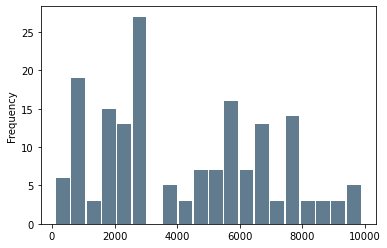

In [62]:
agents.index_ID.plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.ylabel=('Frequency')
plt.xlabel=('Infector')

In [63]:
tot=0
for a in allseq:
    for j in allseq:
        if np.array_equal(allseq[a], allseq[j]):
            tot+=1


In [64]:
tot

1482

In [65]:
all = len(allseq)

In [66]:
all

170

In [67]:
display('Percent of equal sequences: ')
display(tot*100/(all*(all-1)/2))

'Percent of equal sequences: '

10.316742081447964

In [68]:
agents

,accession,location,state,infection_date,index_ID,descendants,recovery,strain,region,country
0,1000,1,R,2020-03-01,NaN,[],2020-03-24,G22670,North America,USA
1,NaN,1,S,NaN,NaN,[],NaN,G22671,North America,USA
2,NaN,1,S,NaN,NaN,[],NaN,G22672,North America,USA
3,NaN,0,S,NaN,NaN,[],NaN,G22673,North America,USA
4,NaN,1,S,NaN,NaN,[],NaN,G22674,North America,USA
...,...,...,...,...,...,...,...,...,...,...
995,NaN,0,S,NaN,NaN,[],NaN,G23665,North America,USA
996,NaN,1,S,NaN,NaN,[],NaN,G23666,North America,USA
997,6304,0,I,2020-03-18,2896,[],2020-03-29,G23667,North America,USA
998,NaN,1,S,NaN,NaN,[],NaN,G23668,North America,USA


In [69]:
base

{'G22670': SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='G22670', name='G22670', description='G22670', dbxrefs=[])}

# 3. Selection

### 3.1 Demographic Info

In [70]:
gnm = agents[agents.state != 'S']

In [71]:
len(allseq.keys())
# all is number of cases
#sample from half of all interested ones

170

In [72]:
len(gnm.accession)

173

In [73]:
loca= []
conv = {}
conv[0]='community A'
conv[1] ='community B'
for i in gnm.location:
    loca.append(conv[i])
gnm['local'] = loca

<ipython-input-73-846e3f917e5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnm['local'] = loca


In [74]:
gnm

,accession,location,state,infection_date,index_ID,descendants,recovery,strain,region,country,local
0,1000,1,R,2020-03-01,NaN,[],2020-03-24,G22670,North America,USA,community B
7,2797,1,R,2020-03-14,4464,[],2020-03-26,G22677,North America,USA,community B
10,896,0,R,2020-03-20,685,[],2020-03-21,G22680,North America,USA,community A
12,8058,1,I,2020-03-31,5895,[],2020-04-01,G22682,North America,USA,community B
23,1123,0,I,2020-03-18,3582,[],2020-03-21,G22693,North America,USA,community A
...,...,...,...,...,...,...,...,...,...,...,...
972,941,1,I,2020-03-28,8083,[],2020-03-30,G23642,North America,USA,community B
981,7349,1,I,2020-03-15,3765,[],2020-04-12,G23651,North America,USA,community B
983,1994,0,I,2020-03-28,8083,[],2020-03-28,G23653,North America,USA,community A
990,5936,1,I,2020-03-04,1000,[],2020-03-06,G23660,North America,USA,community B


In [75]:
gnmA = gnm[gnm.location==0]
gnmB = gnm[gnm.location==1]
display(gnmA.shape, gnmB.shape)

(75, 11)

(98, 11)

# 4. Exporting

In [76]:
gnm.to_csv('sus_all.csv', sep='\t')
agents.to_csv('all_agents.csv', sep='\t')

In [77]:
halfA = int(gnmA.shape[0] / 2)
halfB = int(gnmB.shape[0] /2)
fourthB = int(gnmB.shape[0] / 4)
eighthB = int(gnmB.shape[0] /8)
threefourthB = int(gnmB.shape[0] *3/4)

In [78]:
display(halfB, fourthB, eighthB, threefourthB, "\t")
display(halfA)

49

24

12

73

'\t'

37

In [79]:
ratios = ['','11','12','14','23','21']

In [80]:
gnm11 = gnmA.sample(frac=0.5, random_state=1).append(gnmB.sample(frac=0.5, random_state=1))
gnm12 = gnmA.sample(frac=0.5, random_state=2).append(gnmB.sample(frac=0.25, random_state=2))
gnm14 = gnmA.sample(frac=0.5, random_state=3).append(gnmB.sample(frac=(1/8), random_state=3))
gnm23 = gnmA.sample(frac=0.5, random_state=4).append(gnmB.sample(frac=0.75, random_state=4))
gnm21 = gnmA.sample(frac=0.5, random_state=5).append(gnmB)

In [81]:
display(gnm11.shape, halfA+halfB)
display(gnm12.shape, halfA+fourthB)
display(gnm14.shape, halfA+eighthB)
display(gnm23.shape, halfA+threefourthB)
display(gnm21.shape, halfA+gnmB.shape[0])

(87, 11)

86

(62, 11)

61

(50, 11)

49

(112, 11)

110

(136, 11)

135

In [82]:
gnm.to_csv('background.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)
gnm11.to_csv('background11.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)
gnm12.to_csv('background12.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)
gnm14.to_csv('background14.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)
gnm23.to_csv('background23.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)
gnm21.to_csv('background21.tsv', sep='\t', 
              columns=['strain', 'accession','infection_date','region','country','local'],
             index=False)

In [83]:
allseq.keys()

dict_keys([1000, 2917, 9607, 5936, 198, 3106, 4546, 6608, 6911, 4676, 7922, 5353, 7036, 9990, 2997, 1479, 2240, 5757, 5890, 7069, 685, 5207, 7519, 2215, 2114, 4615, 4196, 4464, 2896, 110, 2854, 1721, 3722, 3823, 2808, 6470, 1198, 2126, 8539, 2363, 6073, 6176, 1817, 1823, 3765, 3570, 2797, 9051, 6412, 8358, 9013, 1838, 7012, 3655, 5829, 3582, 7349, 6551, 1720, 2172, 8257, 68, 7587, 6304, 339, 1123, 7514, 9201, 6219, 9887, 8676, 6422, 6074, 4507, 7003, 7948, 5895, 9382, 9046, 7546, 2381, 1586, 5311, 896, 2077, 7695, 4653, 4620, 5610, 6855, 5469, 5989, 8214, 4154, 1153, 7760, 5897, 2468, 7798, 8083, 675, 7918, 2603, 7828, 7563, 5823, 9529, 712, 2054, 3390, 9671, 2823, 9640, 850, 7683, 2337, 3804, 5646, 5104, 7590, 659, 831, 3538, 8045, 7621, 5122, 3418, 7197, 4717, 265, 4269, 9861, 2147, 5143, 9033, 663, 184, 3803, 6884, 8069, 2453, 165, 2306, 6822, 9412, 1994, 3441, 941, 123, 5845, 2606, 2006, 2193, 202, 1311, 2571, 8235, 1976, 3027, 1219, 8250, 7942, 4788, 8058, 5532, 6555, 4277, 7596, 

In [84]:
allrat = {}
allrat['gnm'] = gnm
allrat['gnm11'] = gnm11
allrat['gnm12'] = gnm12
allrat['gnm14'] = gnm14
allrat['gnm23'] = gnm23
allrat['gnm21'] = gnm21

### 4.2 FASTA File

In [85]:
for a in ratios:
    ofile = open("allseqs{rat}.txt".format(rat=a), "w")

    gnmclr = allrat['gnm{rat}'.format(rat=a)].reset_index()
    for i in gnmclr.index:
        me = allrat['gnm{rat}'.format(rat=a)].iloc[i]
        ofile.write(">" + me.strain + "\n" +''.join(allseq[me.accession]) + "\n")

        #do not forget to close it

    ofile.close()

In [86]:
print(i in gnm.index)

False


# 5 Graphics/Analysis

* still provide initial sequence - youngest count as root in random selection
* see how many of correctly directed edges are present in constructed tree
    * function of the two parameters - % correct
    
TODO:
   * creation and running of snakemake
   * function to determine ground truth - list of directed ages?
   * in/out of nextstrain
   * feed all to see how initially accurate nextstrain is
   * install nesxstrain tools
    
    
  .groupby for infector
- how nextstrain may be off: initial pairs and compare to nexstrain
- coun tnumber of pairs
- divergence on nexstrain
- examine the directed arrows to show who is infecting hwo
* FIGURE OUT HOW TO INTERPRET TREE RESULTING FILE IN NEXTSTRAIN

## 5.1 Directed Graph

In [153]:
gnm

,accession,location,state,infection_date,index_ID,descendants,recovery,strain,region,country,local
0,1000,1,R,2020-03-01,NaN,[],2020-03-24,G22670,North America,USA,community B
7,2797,1,R,2020-03-14,4464,[],2020-03-26,G22677,North America,USA,community B
10,896,0,R,2020-03-20,685,[],2020-03-21,G22680,North America,USA,community A
12,8058,1,I,2020-03-31,5895,[],2020-04-01,G22682,North America,USA,community B
23,1123,0,I,2020-03-18,3582,[],2020-03-21,G22693,North America,USA,community A
...,...,...,...,...,...,...,...,...,...,...,...
972,941,1,I,2020-03-28,8083,[],2020-03-30,G23642,North America,USA,community B
981,7349,1,I,2020-03-15,3765,[],2020-04-12,G23651,North America,USA,community B
983,1994,0,I,2020-03-28,8083,[],2020-03-28,G23653,North America,USA,community A
990,5936,1,I,2020-03-04,1000,[],2020-03-06,G23660,North America,USA,community B


In [101]:
import networkx as nx
from matplotlib.pyplot import figure

In [110]:
gnm.columns

Index(['accession', 'location', 'state', 'infection_date', 'index_ID',
       'descendants', 'recovery', 'strain', 'region', 'country', 'local'],
      dtype='object')

In [142]:
G = nx.MultiDiGraph
G = nx.from_pandas_edgelist(gnm, 'accession', 'index_ID')
G.remove_node(np.nan)

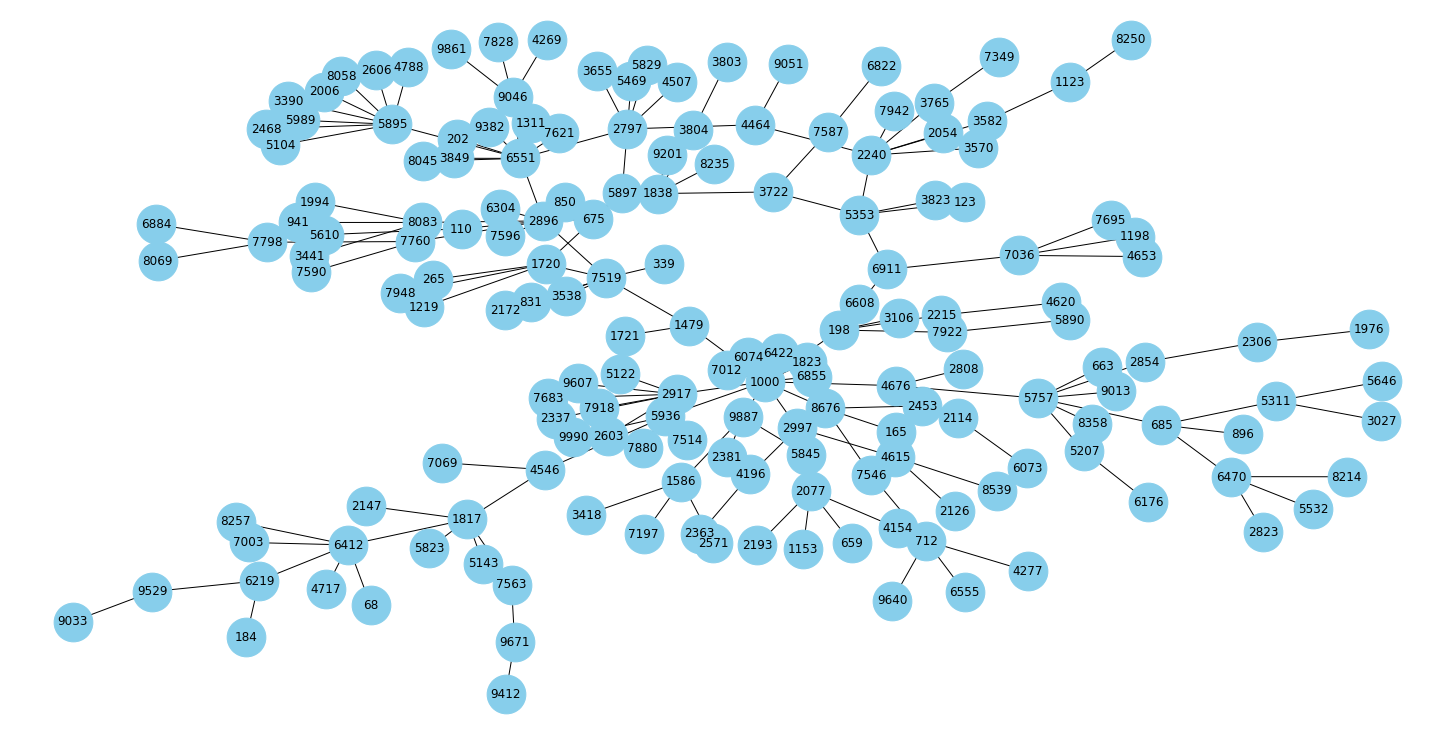

In [149]:
figure(figsize=(20, 10))
nx.draw(G, with_labels=True, node_size=1500, node_color="skyblue", pos=nx.kamada_kawai_layout(G,scale = 1.5))

In [151]:
gnm[gnm.accession==5895]

,accession,location,state,infection_date,index_ID,descendants,recovery,strain,region,country,local
63,5895,0,I,2020-03-20,6551,[],2020-04-05,G22733,North America,USA,community A


In [152]:
'conda activate nextstrain'
'nextstrain build --cpus 1 genomic_sampling/__'

'nextstrain build --cpus 1 genomic_sampling/__'

# 6. Generated Tree vs Simualted

In [162]:
import baltic as bt
import json
from Bio import Phylo

In [322]:
def to_adjacency_matrix(tree):
    """Create an adjacency matrix (NumPy array) from clades/branches in tree.

    Also returns a list of all clades in tree ("allclades"), where the position
    of each clade in the list corresponds to a row and column of the numpy
    array: a cell (i,j) in the array is 1 if there is a branch from allclades[i]
    to allclades[j], otherwise 0.

    Returns a tuple of (allclades, adjacency_matrix) where allclades is a list
    of clades and adjacency_matrix is a NumPy 2D array.
    """
    allclades = list(tree.find_clades(order="level"))
    lookup = {}
    for i, elem in enumerate(allclades):
        lookup[elem] = i
    adjmat = np.zeros((len(allclades), len(allclades)))
    for parent in tree.find_clades(terminal=False, order="level"):
        for child in parent.clades:
            adjmat[lookup[parent], lookup[child]] = 1
    return (allclades, np.matrix(adjmat))

In [ ]:
def see_pairs(tree):
    """Create an adjacency matrix (NumPy array) from clades/branches in tree.

    Also returns a list of all clades in tree ("allclades"), where the position
    of each clade in the list corresponds to a row and column of the numpy
    array: a cell (i,j) in the array is 1 if there is a branch from allclades[i]
    to allclades[j], otherwise 0.

    Returns a tuple of (allclades, adjacency_matrix) where allclades is a list
    of clades and adjacency_matrix is a NumPy 2D array.
    """
    allclades = list(tree.find_clades(order="level"))
    lookup = {}
    for i, elem in enumerate(allclades):
        if str(elem.startswith('G')):
            lookup[elem] = i
    adjmat = np.zeros((len(lookup), len(lookup)))
    for parent in tree.find_clades(terminal=False, order="level"):
        for child in parent.clades:
            adjmat[lookup[parent], lookup[child]] = 1
    return (allclades, np.matrix(adjmat))

In [ ]:
allclades

In [356]:
lookup={}
momkid=[]
allclades = list(tree.find_clades(order="level"))
for i, elem in enumerate(allclades):
        if str(elem).startswith('G'):
            lookup[elem] = i
            #print(i, elem)
for parent in tree.find_clades(order="level"):
    #if parent.name.startswith('G'):
    for child in parent.clades:
        #if child.name.startswith('G'):
        momkid.append((parent.name, child.name))


In [357]:
momkid

[('NODE_0000001', 'NODE_0000136'),
 ('NODE_0000001', 'NODE_0000130'),
 ('NODE_0000136', 'G23651'),
 ('NODE_0000136', 'G23052'),
 ('NODE_0000136', 'NODE_0000002'),
 ('NODE_0000136', 'NODE_0000145'),
 ('NODE_0000130', 'G23165'),
 ('NODE_0000130', 'NODE_0000031'),
 ('NODE_0000130', 'NODE_0000000'),
 ('NODE_0000002', 'NODE_0000003'),
 ('NODE_0000002', 'NODE_0000005'),
 ('NODE_0000145', 'NODE_0000009'),
 ('NODE_0000145', 'NODE_0000147'),
 ('NODE_0000031', 'NODE_0000032'),
 ('NODE_0000031', 'NODE_0000134'),
 ('NODE_0000000', 'base_case'),
 ('NODE_0000000', 'G23486'),
 ('NODE_0000000', 'G23380'),
 ('NODE_0000000', 'G23609'),
 ('NODE_0000000', 'NODE_0000099'),
 ('NODE_0000000', 'NODE_0000089'),
 ('NODE_0000000', 'NODE_0000105'),
 ('NODE_0000000', 'NODE_0000047'),
 ('NODE_0000000', 'NODE_0000066'),
 ('NODE_0000000', 'NODE_0000163'),
 ('NODE_0000003', 'G22702'),
 ('NODE_0000003', 'NODE_0000004'),
 ('NODE_0000005', 'G22757'),
 ('NODE_0000005', 'NODE_0000006'),
 ('NODE_0000009', 'G23625'),
 ('NODE

In [359]:
myTree = bt.loadNewick(nwkpath)

In [363]:
myTree, myMeta = bt.loadJSON(genpath)


Tree height: 0.126479
Tree length: 4.080466
annotations present

Numbers of objects in tree: 317 (143 nodes and 174 leaves)



Type:        module
String form: <module 'baltic' from '/opt/anaconda3/lib/python3.8/site-packages/baltic/__init__.py'>
File:        /opt/anaconda3/lib/python3.8/site-packages/baltic/__init__.py
Docstring:   <no docstring>


In [260]:
genpath = '/Users/naarankin/research/CZB/sampling_bias/genomic_sampling/auspice/genseq00.json'
nwkpath = '/Users/naarankin/research/CZB/sampling_bias/genomic_sampling/ground/results/tree.nwk'

In [235]:
f = open(genpath,)
data = json.load(f)



In [ ]:
# Extract tree edges from the dict
edges = []


get_edges(data)

# Dump edge list in Graphviz DOT format
print('strict digraph tree {')
for row in edges:
    print('    {0} -> {1};'.format(*row))
print('}')

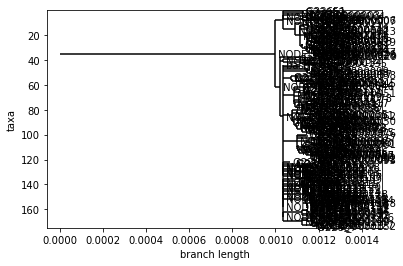

In [282]:
trex = Phylo.read(nwkpath, "newick")
Phylo.draw(trex)

In [ ]:
trees = Phylo.parse(nwkpath, 'newick')
for tree in trees:
    print(tree)


In [323]:
clade, matr = to_adjacency_matrix(tree)

In [324]:
gnm.shape

(173, 11)

In [ ]:
for item in clade:
    print(item, '\t')

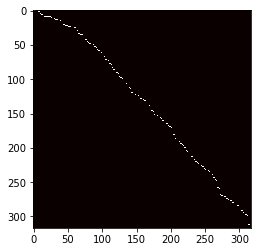

In [326]:
plt.imshow(matr, cmap='hot', interpolation='nearest')
plt.show()